<a href="https://colab.research.google.com/github/fireHedgehog/music-intrument-OvA-model/blob/main/nsynth_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.backend import clear_session
from google.colab import drive


Step 2: Load the NSynth Dataset
TensorFlow Datasets (TFDS) provides a convenient way to load the NSynth dataset. The following code snippet demonstrates how to load the dataset. Note that the NSynth dataset is large, and loading it might take some time.

In [2]:

drive.mount('/content/drive')

dataset_save_path = '/content/drive/My Drive/datasets/'

if not os.path.exists(dataset_save_path):
    os.makedirs(dataset_save_path)
    print(f"Directory created at {dataset_save_path}")
else:
    print(f"Directory already exists at {dataset_save_path}")


# Example saving function
def save_dataset(dataset, save_path):
    tf.data.experimental.save(dataset, save_path)

# Example loading function
def load_dataset(load_path):
    return tf.data.experimental.load(load_path)


# Define the path where you expect the dataset to be stored
dataset_path = os.path.join(tfds.core.constants.DATA_DIR, 'nsynth/gansynth_subset')

# Check if the dataset already exists on disk
if os.path.exists(dataset_path):
    print("Loading dataset from disk...")
    nsynth_dataset = tfds.load('nsynth/gansynth_subset', split='train', shuffle_files=True, data_dir=dataset_path)
else:
    print("Downloading and preparing dataset...")
    nsynth_builder = tfds.builder('nsynth/gansynth_subset')
    nsynth_builder.download_and_prepare()
    nsynth_dataset = nsynth_builder.as_dataset(split='train', shuffle_files=True)
    print("Dataset ready.")

Mounted at /content/drive
Directory already exists at /content/drive/My Drive/datasets/


Dl Completed...:   0%|          | 0/229 [00:00<?, ? file/s]

Dataset nsynth downloaded and prepared to /root/tensorflow_datasets/nsynth/gansynth_subset/2.3.3. Subsequent calls will reuse this data.
Dataset ready.


Step 3: Preprocess the Audio Data
You'll need to preprocess the audio data by converting the audio samples into spectrograms. This involves iterating over the dataset, extracting audio samples, and using librosa to convert these samples into spectrogram

In [3]:
# Mapping from numerical labels to string names
label_map = {
    0: 'bass',
    1: 'brass',
    2: 'flute',
    3: 'guitar',
    4: 'keyboard',
    5: 'mallet',
    6: 'organ',
    7: 'reed',
    8: 'string',
    9: 'synth_lead',
    10: 'vocal',
}

def audio_to_spectrogram(audio_sample, sr=16000, n_fft=2048, hop_length=512):
    """Convert audio to spectrogram."""
    spectrogram = librosa.stft(audio_sample, n_fft=n_fft, hop_length=hop_length)
    spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))
    return spectrogram_db

def preprocess_dataset(nsynth_dataset):
    spectrograms = []
    labels = []
    processed_families = set()

    # for example in nsynth_dataset.take(100):  # Taking only 100 samples for demonstration
    for example in nsynth_dataset:
        family_id = example['instrument']['family'].numpy()
        # Skip if the family has already been processed
        if family_id in processed_families:
            continue
        processed_families.add(family_id)

        audio_sample = example['audio']
        label = label_map[family_id]

        spectrogram = audio_to_spectrogram(audio_sample.numpy())
        spectrograms.append(spectrogram)
        labels.append(label)

         # Stop if we have processed one example per family
        if len(processed_families) == 11:
            break

    return np.array(spectrograms), np.array(labels)


Step 4: Convert Audio Samples to Spectrograms
Use the preprocess_dataset function to convert your audio samples in the dataset to spectrograms. (comment out, for background running)

In [ ]:
"""spectrograms, labels = preprocess_dataset(nsynth_dataset)"""


Step 5: Visualizing a Spectrogram
To ensure that your spectrograms are correctly generated, visualize one using matplotlib. (comment out, for background running)

In [ ]:
"""
import os
import matplotlib.pyplot as plt
import librosa.display

def plot_and_save_spectrograms(spectrograms, labels):
    # Ensure the directory for spectrograms exists
    os.makedirs('./spectrograms', exist_ok=True)

    for i, (spectrogram, label) in enumerate(zip(spectrograms, labels)):
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(spectrogram, y_axis='log', x_axis='time')
        plt.title(f'Label: {label}')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.savefig(f'./spectrograms/spectrogram_{label}.png')  # Save the spectrogram as a PNG file
        plt.close()  # Close the plot to free memory
        plt.show()

plot_and_save_spectrograms(spectrograms, labels)
"""

subplots to a big plot (comment out, for background running)


In [ ]:
"""
import os
import matplotlib.pyplot as plt
import librosa.display

def plot_and_save_combined_spectrograms(spectrograms, labels):
    # Ensure the directory for spectrograms exists
    os.makedirs('./spectrograms', exist_ok=True)

    # Create a figure with subplots
    fig, axs = plt.subplots(5, 2, figsize=(15, 25))
    axs = axs.flatten()  # Flatten the array for easy indexing

    for i, (spectrogram, label) in enumerate(zip(spectrograms, labels)):
        ax = axs[i]
        img = librosa.display.specshow(spectrogram, y_axis='log', x_axis='time', ax=ax)
        ax.set_title(f'Label: {label}')
        fig.colorbar(img, ax=ax, format='%+2.0f dB')

    # Adjust layout
    plt.tight_layout()

    # Save the combined figure as a PNG file
    plt.savefig('./spectrograms/combined_spectrograms.png')
    plt.close(fig)  # Close the figure to free memory

# Example usage:
# plot_and_save_combined_spectrograms(spectrograms[:11], labels[:11])

plot_and_save_combined_spectrograms(spectrograms, labels)
"""

Step 6: Define the Model Architecture
Use the CNN architecture you've established or any variations you prefer. Ensure it's suitable for binary classification.

In [4]:
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model




load data


In [5]:
nsynth_train = tfds.load('nsynth/gansynth_subset', split='train', shuffle_files=True)
nsynth_valid = tfds.load('nsynth/gansynth_subset', split='valid', shuffle_files=True)  # Assuming 'test' as validation
nsynth_test = tfds.load('nsynth/gansynth_subset', split='test', shuffle_files=True)

save to google drive

In [ ]:
# save_dataset(nsynth_train, os.path.join(dataset_save_path, 'nsynth_train'))
# save_dataset(nsynth_valid, os.path.join(dataset_save_path, 'nsynth_valid'))
# save_dataset(nsynth_test, os.path.join(dataset_save_path, 'nsynth_test'))
# save_dataset(fuss_dataset, os.path.join(dataset_save_path, 'fuss_dataset'))

Preprocess the Data
Convert audio files to spectrograms, normalize, and prepare binary labels. Here's a simplified preprocessing function:

In [6]:
def audio_to_spectrogram(audio_sample, sr=16000, n_fft=2048, hop_length=512):
    """Convert audio to spectrogram."""
    spectrogram = librosa.stft(audio_sample, n_fft=n_fft, hop_length=hop_length)
    spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))
    return spectrogram_db


get 11 array for each instrument


In [7]:
# Dictionary to hold the spectrogram arrays for each instrument family
x_train_dict = {}
y_train_dict = {}

# Loop through each family ID
for family_id in range(11):

    if family_id == 9:
        continue

    family_name = label_map.get(family_id, None)
    if not family_name:
        continue  # Skip if the family is not in the adjusted label_map

    # Initialize arrays to hold data and labels for the current family
    x_train_family = []
    y_train_family = []


    sample_counter = 0
    # Iterate through the dataset to filter examples for the current family
    # for example in nsynth_dataset.take(20000):
    for example in nsynth_train:
         # Initialize a counter for samples per family

        if example['instrument']['family'].numpy() == family_id:
            # Convert the audio sample to a spectrogram
            spectrogram = audio_to_spectrogram(example['audio'].numpy())
            x_train_family.append(spectrogram)

            # Add a label indicating presence of the family's instrument
            y_train_family.append(1)
            # Increment the sample counter
            sample_counter += 1
            if sample_counter >= 1000:  # Break after collecting 500 samples
                break

    # Convert lists to numpy arrays and store them in the dictionaries
    x_train_dict[family_name] = np.array(x_train_family)
    y_train_dict[family_name] = np.array(y_train_family)

# Now, x_train_dict and y_train_dict contain the training data and labels for each family
# For example, to access the bass training data and labels:
# x_train_bass = x_train_dict['bass']
# y_train_bass = y_train_dict['bass']


Augmenting Data: The function augment_with_negative_examples takes positive examples for the current family and combines them with a sampled set of negative examples from other families.
Balancing Classes: It aims to balance the number of positive and negative examples. Adjust the sampling logic as necessary based on your dataset's specifics and desired class balance.
Shuffling: It's crucial to shuffle the combined dataset to ensure the model doesn't learn the order of examples.
Model Input Shape: Ensure the input shape for create_model is derived from the augmented dataset's shape.

In [8]:
# Assuming x_train_dict and y_train_dict are already populated with positive examples

def augment_with_negative_examples(x_train, y_train, family_name, x_train_dict, sample_size):
    # Gather negative samples from other families
    x_negatives = []
    for other_family in x_train_dict:
        if other_family != family_name:
            x_negatives.extend(x_train_dict[other_family][:sample_size])

    # Create negative labels
    y_negatives = [0] * len(x_negatives)

    # Combine positive and negative examples
    x_train_augmented = np.concatenate((x_train, np.array(x_negatives)), axis=0)
    y_train_augmented = np.concatenate((y_train, y_negatives), axis=0)

    # Shuffle the combined dataset to mix positive and negative examples
    permutation = np.random.permutation(len(x_train_augmented))
    x_train_augmented = x_train_augmented[permutation]
    y_train_augmented = y_train_augmented[permutation]

    return x_train_augmented, y_train_augmented


Train Each Classifier
Loop through each instrument family, create a binary classification dataset, and train a model:

Physical devices cannot be modified after being initialized
Epoch 1/1000
33/33 [==============================] - 11s 91ms/step - loss: 3.8289 - accuracy: 0.8760 - val_loss: 76.5137 - val_accuracy: 0.9198
Epoch 2/1000
33/33 [==============================] - 1s 41ms/step - loss: 0.2368 - accuracy: 0.8912 - val_loss: 15.1322 - val_accuracy: 0.9198
Epoch 3/1000
33/33 [==============================] - 1s 41ms/step - loss: 0.1709 - accuracy: 0.8931 - val_loss: 0.9397 - val_accuracy: 0.9198
Epoch 4/1000
33/33 [==============================] - 1s 41ms/step - loss: 0.1527 - accuracy: 0.9227 - val_loss: 0.1835 - val_accuracy: 0.9580
Epoch 5/1000
33/33 [==============================] - 1s 41ms/step - loss: 0.1132 - accuracy: 0.9513 - val_loss: 0.2059 - val_accuracy: 0.9618
Epoch 6/1000
33/33 [==============================] - 1s 41ms/step - loss: 0.1095 - accuracy: 0.9542 - val_loss: 0.0683 - val_accuracy: 0.9962
Epoch 7/1000
33/33 [==============================] - 1s 41ms/step - loss: 0.13

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


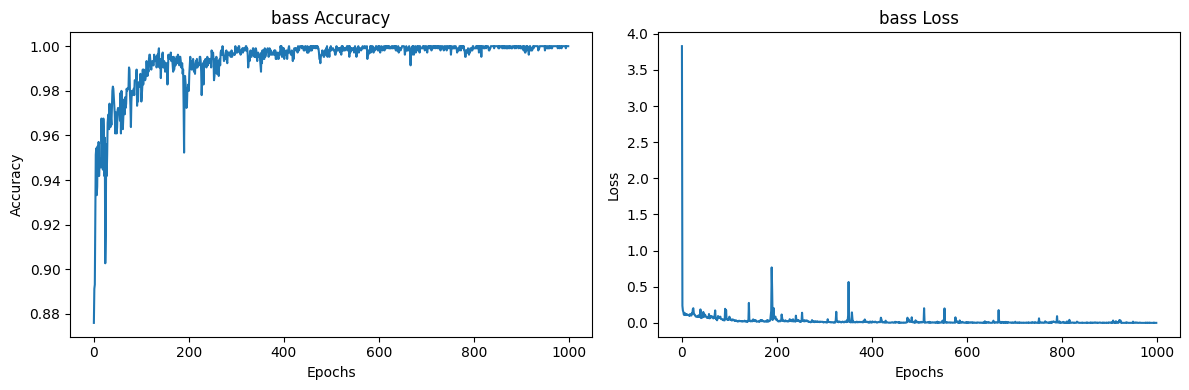

Epoch 1/1000
206/206 [==============================] - 13s 53ms/step - loss: 2.6274 - accuracy: 0.8622 - val_loss: 0.2606 - val_accuracy: 0.8950
Epoch 2/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.3425 - accuracy: 0.8865 - val_loss: 0.2092 - val_accuracy: 0.9132
Epoch 3/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2304 - accuracy: 0.8880 - val_loss: 0.2859 - val_accuracy: 0.8841
Epoch 4/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2014 - accuracy: 0.8948 - val_loss: 0.1314 - val_accuracy: 0.9405
Epoch 5/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2183 - accuracy: 0.8917 - val_loss: 0.1595 - val_accuracy: 0.9017
Epoch 6/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.1727 - accuracy: 0.9049 - val_loss: 0.1042 - val_accuracy: 0.9478
Epoch 7/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2965 - accuracy: 0.8900 - val_loss: 0.2196 - val_a

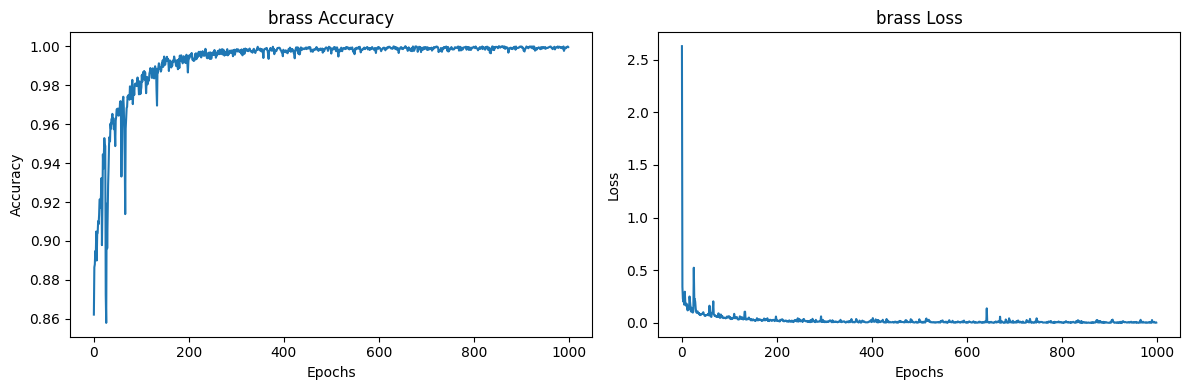

Epoch 1/1000
206/206 [==============================] - 12s 46ms/step - loss: 3.3302 - accuracy: 0.8677 - val_loss: 0.2747 - val_accuracy: 0.9017
Epoch 2/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2874 - accuracy: 0.8914 - val_loss: 0.2083 - val_accuracy: 0.9120
Epoch 3/1000
206/206 [==============================] - 8s 40ms/step - loss: 0.2522 - accuracy: 0.8910 - val_loss: 0.1610 - val_accuracy: 0.9193
Epoch 4/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.1957 - accuracy: 0.8933 - val_loss: 0.1595 - val_accuracy: 0.9175
Epoch 5/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2027 - accuracy: 0.8976 - val_loss: 0.1516 - val_accuracy: 0.9157
Epoch 6/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.1665 - accuracy: 0.8971 - val_loss: 0.1232 - val_accuracy: 0.9211
Epoch 7/1000
206/206 [==============================] - 8s 40ms/step - loss: 0.1725 - accuracy: 0.8985 - val_loss: 0.1124 - val_a

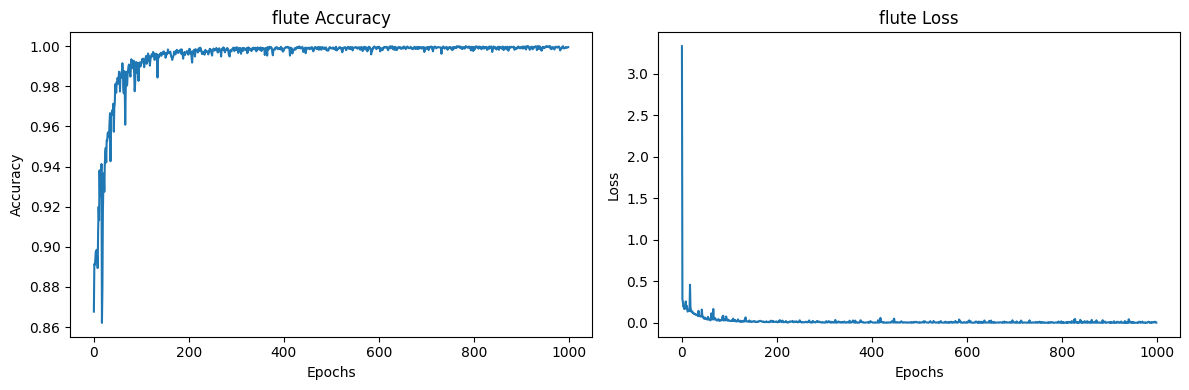

Epoch 1/1000
206/206 [==============================] - 12s 46ms/step - loss: 1.9649 - accuracy: 0.8710 - val_loss: 0.2618 - val_accuracy: 0.8823
Epoch 2/1000
206/206 [==============================] - 8s 40ms/step - loss: 0.3287 - accuracy: 0.8819 - val_loss: 0.2056 - val_accuracy: 0.8908
Epoch 3/1000
206/206 [==============================] - 8s 40ms/step - loss: 0.2489 - accuracy: 0.8833 - val_loss: 0.4027 - val_accuracy: 0.8580
Epoch 4/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2389 - accuracy: 0.8810 - val_loss: 0.2240 - val_accuracy: 0.8738
Epoch 5/1000
206/206 [==============================] - 8s 40ms/step - loss: 0.2070 - accuracy: 0.8804 - val_loss: 0.1829 - val_accuracy: 0.8750
Epoch 6/1000
206/206 [==============================] - 8s 40ms/step - loss: 0.1845 - accuracy: 0.8869 - val_loss: 0.1505 - val_accuracy: 0.8871
Epoch 7/1000
206/206 [==============================] - 8s 40ms/step - loss: 0.1798 - accuracy: 0.8866 - val_loss: 0.1641 - val_a

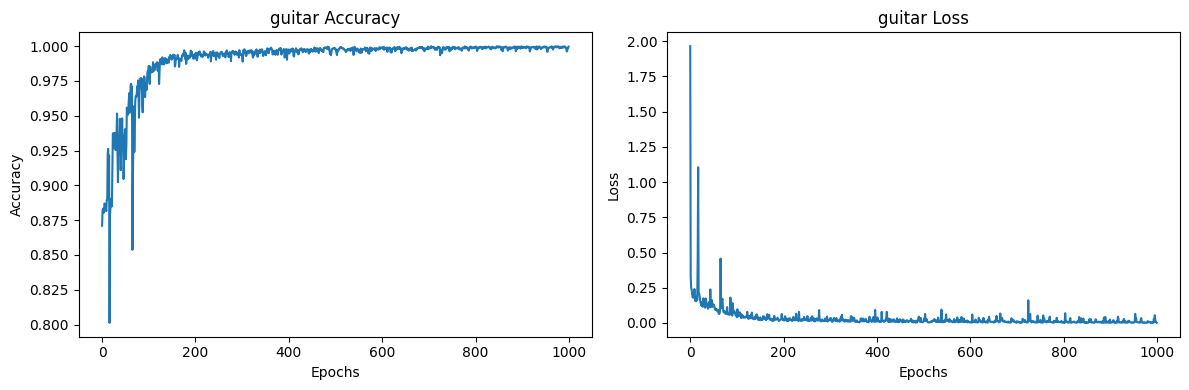

Epoch 1/1000
206/206 [==============================] - 12s 46ms/step - loss: 3.3932 - accuracy: 0.8680 - val_loss: 0.3526 - val_accuracy: 0.8768
Epoch 2/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2820 - accuracy: 0.8945 - val_loss: 0.2045 - val_accuracy: 0.8823
Epoch 3/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2100 - accuracy: 0.8926 - val_loss: 0.1235 - val_accuracy: 0.9539
Epoch 4/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2058 - accuracy: 0.9120 - val_loss: 0.5992 - val_accuracy: 0.8726
Epoch 5/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2293 - accuracy: 0.8777 - val_loss: 0.1532 - val_accuracy: 0.8811
Epoch 6/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.1794 - accuracy: 0.9042 - val_loss: 1.5007 - val_accuracy: 0.7184
Epoch 7/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.3504 - accuracy: 0.8819 - val_loss: 0.1628 - val_a

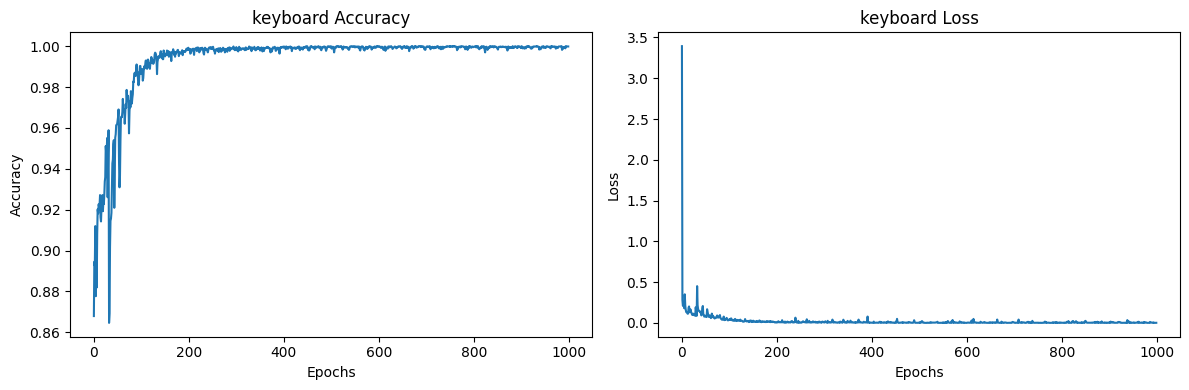

Epoch 1/1000
206/206 [==============================] - 12s 47ms/step - loss: 2.7440 - accuracy: 0.8895 - val_loss: 1.0428 - val_accuracy: 0.9138
Epoch 2/1000
206/206 [==============================] - 9s 41ms/step - loss: 1.1702 - accuracy: 0.8920 - val_loss: 2.4933 - val_accuracy: 0.8635
Epoch 3/1000
206/206 [==============================] - 9s 42ms/step - loss: 0.5268 - accuracy: 0.8930 - val_loss: 0.7055 - val_accuracy: 0.9132
Epoch 4/1000
206/206 [==============================] - 9s 41ms/step - loss: 0.3682 - accuracy: 0.9088 - val_loss: 8.4987 - val_accuracy: 0.8629
Epoch 5/1000
206/206 [==============================] - 9s 41ms/step - loss: 0.3067 - accuracy: 0.9126 - val_loss: 0.1525 - val_accuracy: 0.9460
Epoch 6/1000
206/206 [==============================] - 9s 42ms/step - loss: 0.3596 - accuracy: 0.9131 - val_loss: 1.6862 - val_accuracy: 0.9023
Epoch 7/1000
206/206 [==============================] - 9s 41ms/step - loss: 0.1942 - accuracy: 0.8906 - val_loss: 0.1244 - val_a

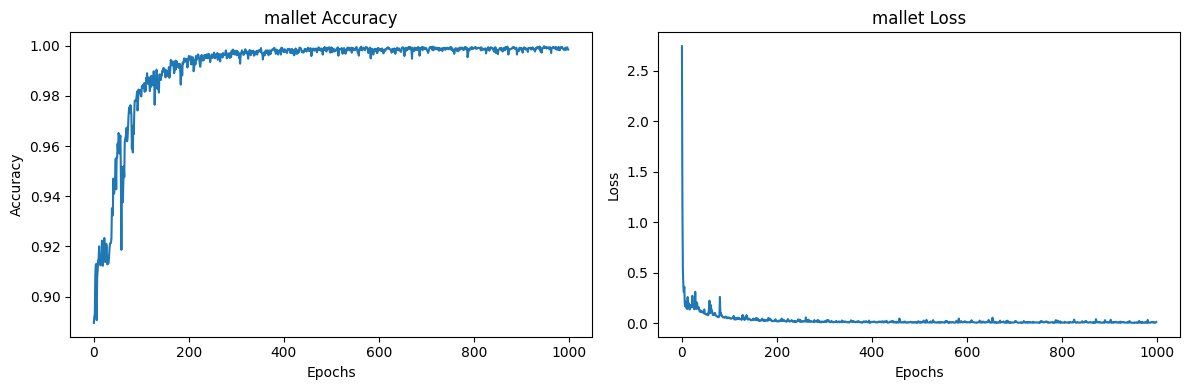

Epoch 1/1000
26/26 [==============================] - 4s 54ms/step - loss: 9.4076 - accuracy: 0.9002 - val_loss: 9.6019 - val_accuracy: 0.9038
Epoch 2/1000
26/26 [==============================] - 1s 42ms/step - loss: 1.4898 - accuracy: 0.9399 - val_loss: 7.7223 - val_accuracy: 0.8990
Epoch 3/1000
26/26 [==============================] - 1s 42ms/step - loss: 0.8048 - accuracy: 0.9459 - val_loss: 1.5049 - val_accuracy: 0.8942
Epoch 4/1000
26/26 [==============================] - 1s 42ms/step - loss: 0.3583 - accuracy: 0.9591 - val_loss: 1.1181 - val_accuracy: 0.8413
Epoch 5/1000
26/26 [==============================] - 1s 42ms/step - loss: 0.2848 - accuracy: 0.9579 - val_loss: 4.1791 - val_accuracy: 0.7212
Epoch 6/1000
26/26 [==============================] - 1s 42ms/step - loss: 0.4733 - accuracy: 0.9760 - val_loss: 1.9304 - val_accuracy: 0.7404
Epoch 7/1000
26/26 [==============================] - 1s 42ms/step - loss: 0.1033 - accuracy: 0.9579 - val_loss: 0.5428 - val_accuracy: 0.8654

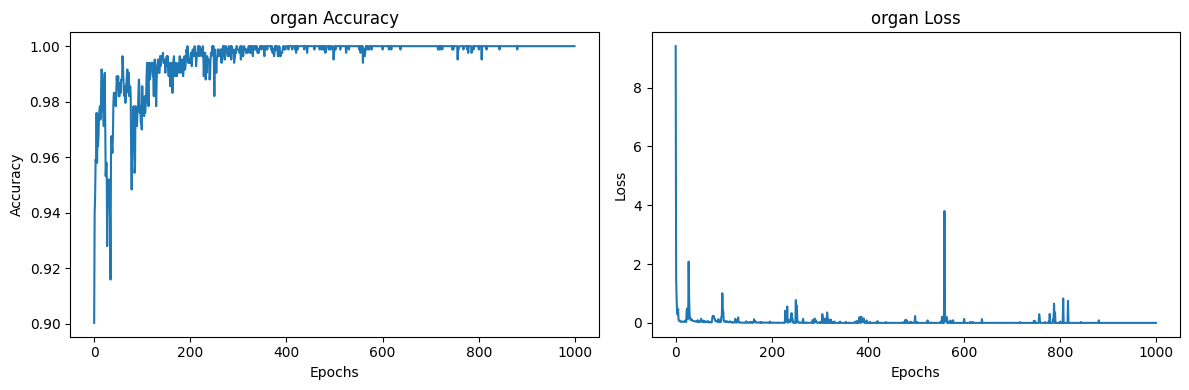

Epoch 1/1000
206/206 [==============================] - 12s 46ms/step - loss: 3.3109 - accuracy: 0.8622 - val_loss: 0.4362 - val_accuracy: 0.8956
Epoch 2/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.3197 - accuracy: 0.8775 - val_loss: 0.3315 - val_accuracy: 0.8908
Epoch 3/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2935 - accuracy: 0.8759 - val_loss: 0.2170 - val_accuracy: 0.8883
Epoch 4/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2725 - accuracy: 0.8762 - val_loss: 0.2356 - val_accuracy: 0.8883
Epoch 5/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2459 - accuracy: 0.8763 - val_loss: 0.2391 - val_accuracy: 0.8883
Epoch 6/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2869 - accuracy: 0.8756 - val_loss: 0.2465 - val_accuracy: 0.8883
Epoch 7/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2354 - accuracy: 0.8765 - val_loss: 0.2234 - val_a

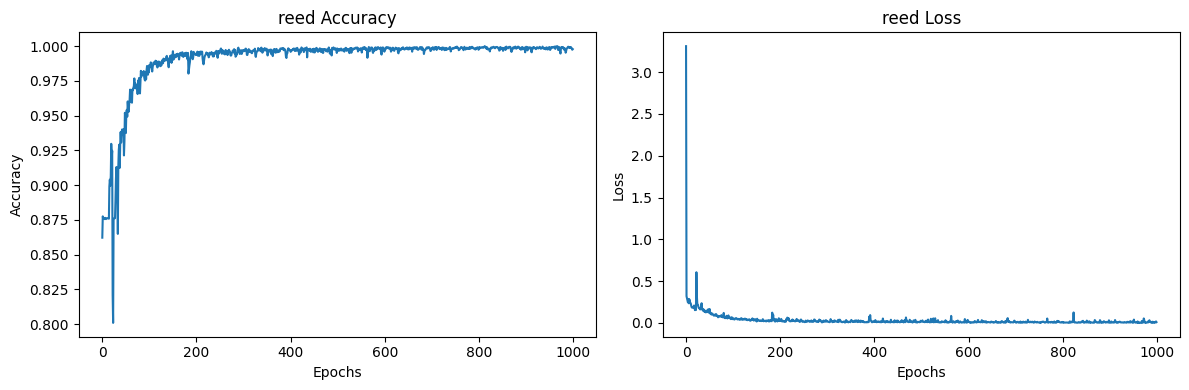

Epoch 1/1000
206/206 [==============================] - 12s 46ms/step - loss: 3.5716 - accuracy: 0.8584 - val_loss: 0.2889 - val_accuracy: 0.8689
Epoch 2/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2944 - accuracy: 0.8806 - val_loss: 0.1969 - val_accuracy: 0.8695
Epoch 3/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2758 - accuracy: 0.8807 - val_loss: 0.1867 - val_accuracy: 0.8677
Epoch 4/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2261 - accuracy: 0.8821 - val_loss: 0.1872 - val_accuracy: 0.8701
Epoch 5/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.2168 - accuracy: 0.8822 - val_loss: 0.1615 - val_accuracy: 0.8726
Epoch 6/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.1922 - accuracy: 0.8895 - val_loss: 0.1353 - val_accuracy: 0.9029
Epoch 7/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.1682 - accuracy: 0.8954 - val_loss: 0.1372 - val_a

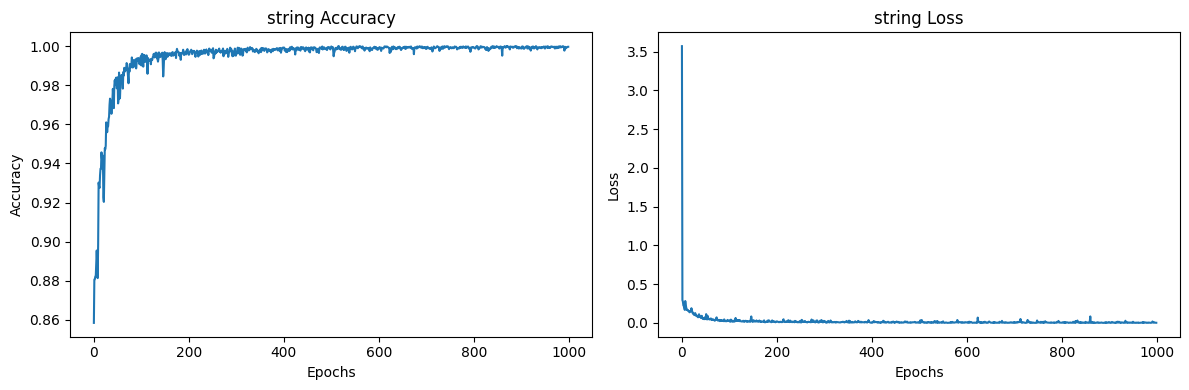

Epoch 1/1000
206/206 [==============================] - 12s 46ms/step - loss: 1.6063 - accuracy: 0.9219 - val_loss: 8.4239 - val_accuracy: 0.9059
Epoch 2/1000
206/206 [==============================] - 9s 41ms/step - loss: 0.1016 - accuracy: 0.9580 - val_loss: 0.1608 - val_accuracy: 0.9739
Epoch 3/1000
206/206 [==============================] - 9s 41ms/step - loss: 0.1218 - accuracy: 0.9596 - val_loss: 0.0179 - val_accuracy: 0.9939
Epoch 4/1000
206/206 [==============================] - 9s 41ms/step - loss: 0.0787 - accuracy: 0.9663 - val_loss: 0.2585 - val_accuracy: 0.9569
Epoch 5/1000
206/206 [==============================] - 9s 41ms/step - loss: 0.0573 - accuracy: 0.9745 - val_loss: 0.1669 - val_accuracy: 0.9800
Epoch 6/1000
206/206 [==============================] - 8s 41ms/step - loss: 0.0640 - accuracy: 0.9762 - val_loss: 0.0184 - val_accuracy: 0.9921
Epoch 7/1000
206/206 [==============================] - 9s 41ms/step - loss: 0.0511 - accuracy: 0.9716 - val_loss: 0.0062 - val_a

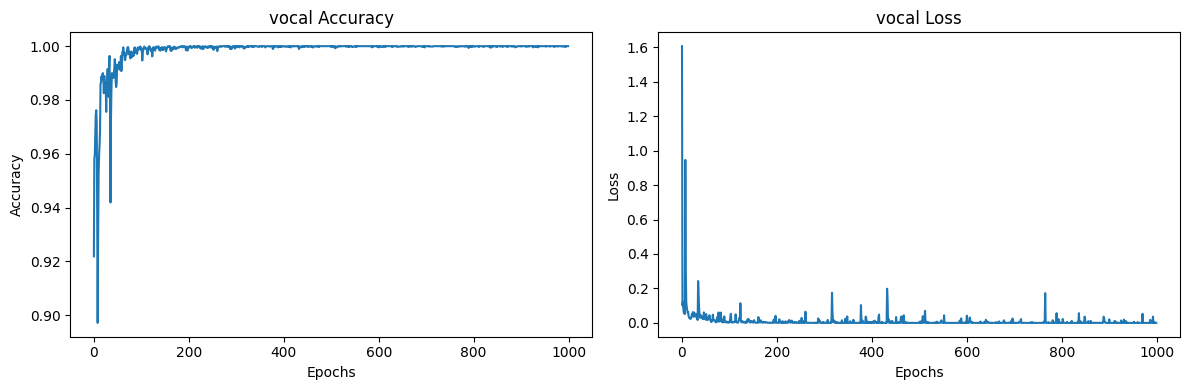

In [9]:
# Define the base directory within Google Drive to save the models and metrics
base_dir = '/content/drive/MyDrive/output/'

models_dir = os.path.join(base_dir, 'models')
metrics_dir = os.path.join(base_dir, 'metrics')

# Create the directories if they do not exist
os.makedirs(models_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)


import gc

# Explicitly set TensorFlow to use dynamic GPU memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

def clear_gpu_memory():
    """
    Clear GPU memory by explicitly deleting models and objects and then
    collecting garbage.
    """
    # Attempt to clear session
    clear_session()

    # Manually collect garbage
    gc.collect()

    # If necessary, additional manual deletion of variables can be done here
    # del model, x_train, y_train, etc.



for family_id in range(11):

    if family_id == 9:
        continue

    family_name = label_map[family_id]

    x_train = x_train_dict[family_name]
    y_train = y_train_dict[family_name]

    # Determine sample size for negative examples
    positive_sample_size = len(x_train)
    x_train_augmented, y_train_augmented = augment_with_negative_examples(x_train, y_train, family_name, x_train_dict, positive_sample_size)

    x_train_augmented = np.array([np.expand_dims(x, -1) for x in x_train_augmented])
    model = create_model(input_shape=x_train_augmented[0].shape)
    history = model.fit(x_train_augmented, y_train_augmented, validation_split=0.2, epochs=1000)

    # Save model
    # model.save(f'./models/family_{family_name}_classifier.h5')
    # Save model to google drive
    model_save_path = os.path.join(models_dir, f'family_{family_name}_classifier.h5')
    model.save(model_save_path)

    # Save training metrics
    #with open(f'./metrics/{family_name}_train_loss.txt', 'w') as f_loss, \
    #     open(f'./metrics/{family_name}_train_acc.txt', 'w') as f_acc:
    #    for loss, acc in zip(history.history['loss'], history.history['accuracy']):
    #        f_loss.write(f"{loss}\n")
    #        f_acc.write(f"{acc}\n")

    # Save training metrics to google drive
    loss_file_path = os.path.join(metrics_dir, f'{family_name}_train_loss.txt')
    acc_file_path = os.path.join(metrics_dir, f'{family_name}_train_acc.txt')

    with open(loss_file_path, 'w') as f_loss, open(acc_file_path, 'w') as f_acc:
        for loss, acc in zip(history.history['loss'], history.history['accuracy']):
          f_loss.write(f"{loss}\n")
          f_acc.write(f"{acc}\n")

    # Clear the current TensorFlow graph and create a new one
    # Useful to ensure the GPU memory is freed
    # Call clear_gpu_memory at the end of each loop iteration
    clear_gpu_memory()

    # Optionally, you can also manually set the TensorFlow device to CPU
    # to ensure that GPU memory is completely cleared. This might not be necessary,
    # but you can uncomment the following lines if you want to be extra sure.
    # with tf.device('/cpu:0'):
    #     model = create_model()
    #     train_model(model)

    # Define the directory within Google Drive to save the plots
    plots_dir = os.path.join(base_dir, 'plots')

    # Create the directory if it does not exist
    os.makedirs(plots_dir, exist_ok=True)

    # Generate and save the plots
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(history.history['accuracy'], label='Accuracy')
    axs[0].set_title(f'{family_name} Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')

    axs[1].plot(history.history['loss'], label='Loss')
    axs[1].set_title(f'{family_name} Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')

    plt.tight_layout()
    # Important: plt.show() is moved after plt.savefig() to ensure the plot is saved before being displayed
    plot_save_path = os.path.join(plots_dir, f'{family_name}_curve.png')
    plt.savefig(plot_save_path)
    plt.show()
    plt.close()



Iterate through the test dataset, predict with each trained model, and collect predictions and true labels.

In [10]:
from tensorflow.keras.models import load_model

predicted_labels = []
true_labels = []

# New base directory for output
base_dir = '/content/drive/MyDrive/output/'

# Directories for models and metrics within the base directory
models_dir = os.path.join(base_dir, 'models')
# metrics_dir = os.path.join(base_dir, 'metrics') # Uncomment if you need to access metrics

# Initialize a dictionary to cache the loaded models
model_cache = {}

# Loop through each family name and attempt to load the corresponding model
for family_id, family_name in label_map.items():
    if family_id == 9:
        continue

    # Construct the path to the model file within Google Drive
    model_path = os.path.join(models_dir, f'family_{family_name}_classifier.h5')

    # Check if the model file exists at the specified path
    if os.path.exists(model_path):
        # Load the model and store it in the cache
        model_cache[family_name] = load_model(model_path)
    else:
        print(f"Model for {family_name} not found at {model_path}")
# At this point, model_cache will contain all successfully loaded models

# for example in nsynth_test.take(100):  # Example modification for quick testing
for example in nsynth_test:
    audio_sample = example['audio'].numpy()

    spectrogram = audio_to_spectrogram(audio_sample)
    spectrogram = np.expand_dims(np.expand_dims(spectrogram, 0), -1)  # Correctly reshape

    true_label = example['instrument']['family'].numpy()

    if true_label == 9:
        continue

    true_labels.append(true_label)

    # Store predictions with their probabilities
    prediction_probs = {}
    for family_id, family_name in label_map.items():

        if family_id == 9:
            continue  # Skip this family ID

        model = model_cache[family_name]

        # Get prediction probability for the positive class
        prob = model.predict(spectrogram)[0]
        prediction_probs[family_id] = prob

    # Select the class with the highest probability
    if prediction_probs:
        predicted_label = max(prediction_probs, key=prediction_probs.get)
    else:
        predicted_label = None  # Handle case with no predictions

    predicted_labels.append(predicted_label)

# Convert lists to arrays for easier handling
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


# Define the base directory in Google Drive where you want to save the test results
test_results_dir = '/content/drive/MyDrive/output/tests/'

# Ensure the directory exists
os.makedirs(test_results_dir, exist_ok=True)

# Define the full path for the files to save
true_label_path = os.path.join(test_results_dir, 'true_label.txt')
predicted_labels_path = os.path.join(test_results_dir, 'predicted_labels.txt')

# Save true and predicted labels for further analysis
np.savetxt(true_label_path, true_labels, fmt='%d')
np.savetxt(predicted_labels_path, predicted_labels, fmt='%d')

print(f"True labels saved to: {true_label_path}")
print(f"Predicted labels saved to: {predicted_labels_path}")


1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 104ms/step


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
True labels saved to: /content/drive/MyDrive/output/tests/true_label.txt
Predicted labels saved to: /content/drive/MyDrive/output/tests/predicted_labels.txt


get blanced test set:

In [ ]:
from collections import defaultdict
import random

# Function to preprocess and extract a balanced dataset
def build_balanced_dataset(nsynth_train, nsynth_valid, nsynth_test, target_samples=100):
    # Combine datasets to pool samples from
    combined_dataset = nsynth_train.concatenate(nsynth_valid).concatenate(nsynth_test)

    # Initialize a dictionary to store examples by class
    class_samples = defaultdict(list)

    # Iterate over the combined dataset to classify examples by instrument family
    for example in tfds.as_numpy(combined_dataset):
        label = example['instrument']['family']
        # Skip class 9 as per requirement
        if label != 9:
            class_samples[label].append(example)

    # Initialize list for balanced dataset
    balanced_dataset = []

    # Iterate over each class to select samples
    for label, examples in class_samples.items():
        # Ensure each class has exactly target_samples examples
        if len(examples) >= target_samples:
            # Randomly sample target_samples examples
            balanced_samples = random.sample(examples, target_samples)
        else:
            # If not enough samples, use what's available (shouldn't happen with correct setup)
            balanced_samples = examples
        balanced_dataset.extend(balanced_samples)

    # Return the balanced dataset
    return balanced_dataset

# Build a balanced dataset
balanced_dataset = build_balanced_dataset(nsynth_train, nsynth_valid, nsynth_test)

predicted_labels_blc = []
true_labels_blc = []

for example in balanced_dataset:
    audio_sample = example['audio']  # Already a NumPy array, no need for .numpy()

    spectrogram = audio_to_spectrogram(audio_sample)
    spectrogram = np.expand_dims(np.expand_dims(spectrogram, 0), -1)  # Correctly reshape

    true_label = example['instrument']['family']  # Already a NumPy value, no need for .numpy()
    if true_label == 9:
        continue

    true_labels_blc.append(true_label)

    # Store predictions with their probabilities
    prediction_probs = {}
    for family_id, family_name in label_map.items():

        if family_id == 9:
            continue  # Skip this family ID

        model = model_cache[family_name]

        # Get prediction probability for the positive class
        prob = model.predict(spectrogram)[0]
        prediction_probs[family_id] = prob

    # Select the class with the highest probability
    if prediction_probs:
        predicted_label = max(prediction_probs, key=prediction_probs.get)
    else:
        predicted_label = None  # Handle case with no predictions

    predicted_labels_blc.append(predicted_label)

# Convert lists to arrays for easier handling
true_labels = np.array(predicted_labels_blc)
predicted_labels = np.array(predicted_labels_blc)


# Define the base directory in Google Drive where you want to save the test results
test_results_dir = '/content/drive/MyDrive/output/tests_blc/'

# Ensure the directory exists
os.makedirs(test_results_dir, exist_ok=True)

# Define the full path for the files to save
true_label_path_blc = os.path.join(test_results_dir, 'true_label_blc.txt')
predicted_labels_path_blc = os.path.join(test_results_dir, 'predicted_labels_blc.txt')

# Save true and predicted labels for further analysis
np.savetxt(true_label_path_blc, true_labels_blc, fmt='%d')
np.savetxt(predicted_labels_path_blc, predicted_labels_blc, fmt='%d')

from sklearn.metrics import classification_report, confusion_matrix

label_map_no_syn_blc = {
    0: 'bass',
    1: 'brass',
    2: 'flute',
    3: 'guitar',
    4: 'keyboard',
    5: 'mallet',
    6: 'organ',
    7: 'reed',
    8: 'string',
    # 9: 'synth_lead',
    10: 'vocal',
}

# Compute metrics for each class
print(classification_report(true_labels_blc, predicted_labels_blc, target_names=label_map_no_syn_blc.values()))

# Compute confusion matrix
conf_matrix_blc = confusion_matrix(true_labels_blc, predicted_labels_blc)
print(conf_matrix_blc)

# Additional metrics like TP, TN, FP, FN can be derived from the confusion matrix if needed.

1/1 [==============================] - 0s 28ms/step


After collecting predictions and true labels, compute and print evaluation metrics for each class.



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

label_map_no_syn = {
    0: 'bass',
    1: 'brass',
    2: 'flute',
    3: 'guitar',
    4: 'keyboard',
    5: 'mallet',
    6: 'organ',
    7: 'reed',
    8: 'string',
    # 9: 'synth_lead',
    10: 'vocal',
}

# Compute metrics for each class
print(classification_report(true_labels, predicted_labels, target_names=label_map_no_syn.values()))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

# Additional metrics like TP, TN, FP, FN can be derived from the confusion matrix if needed.

Overlay example


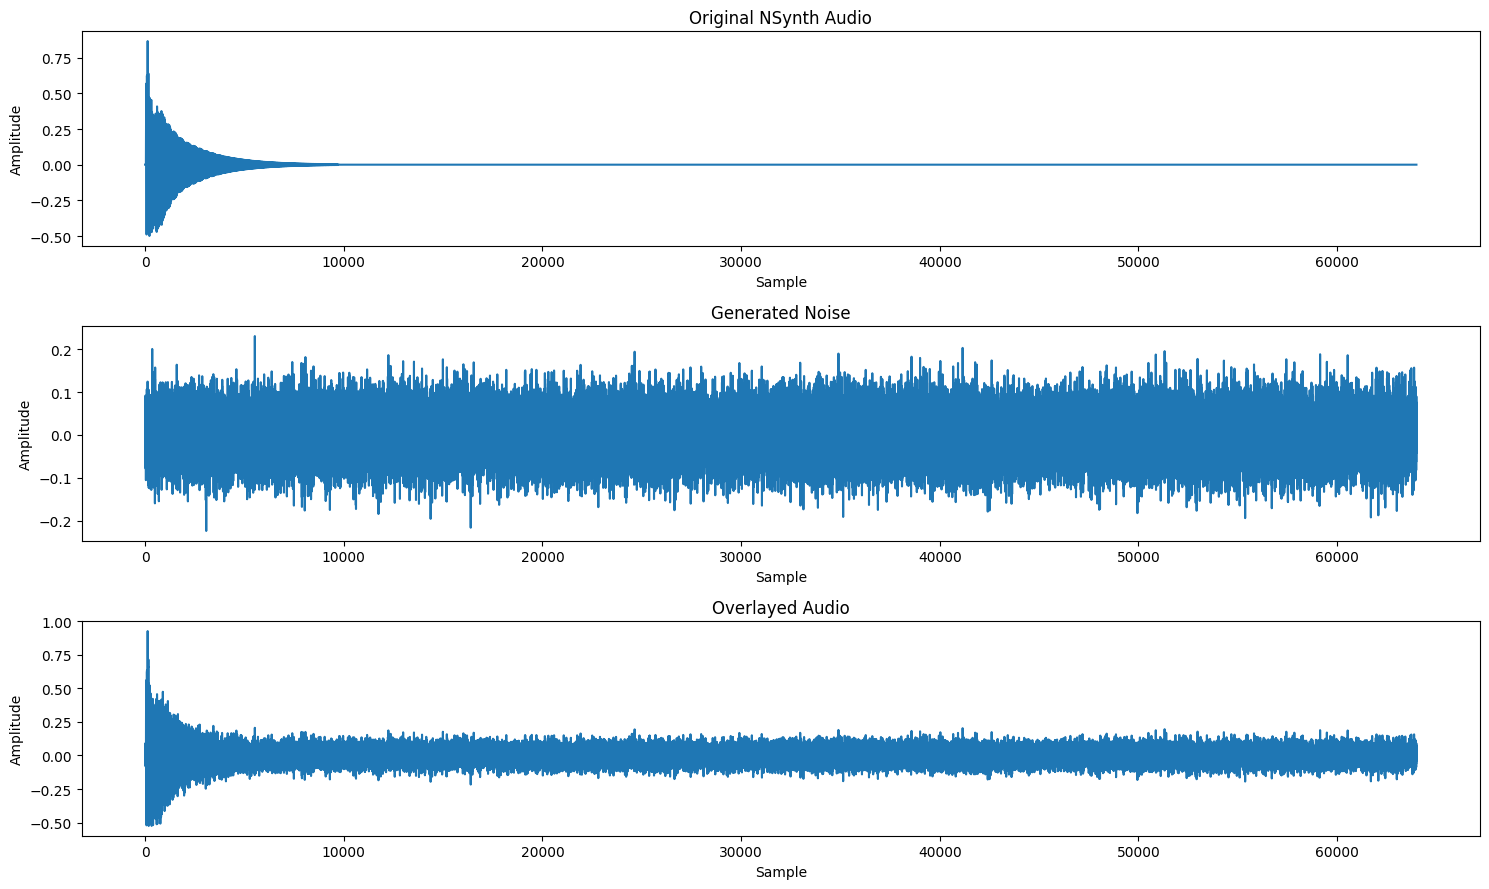

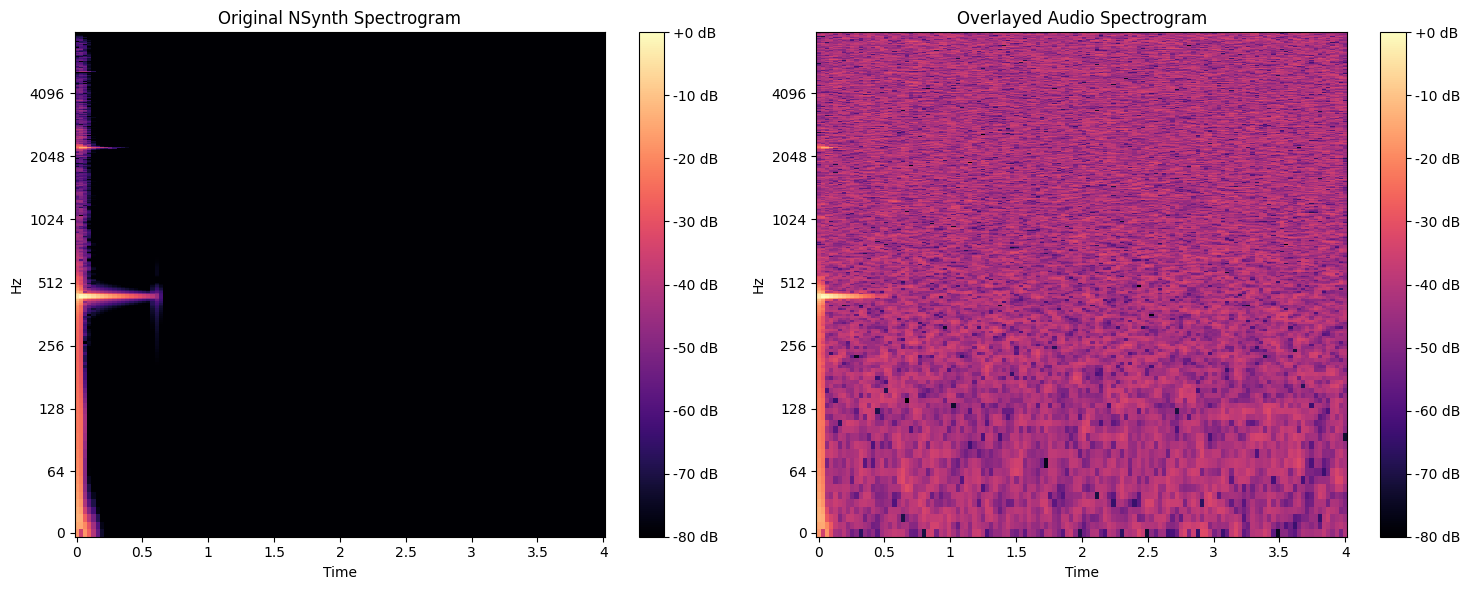

In [ ]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import librosa.display
import tensorflow_datasets as tfds


# Load one sample from the NSynth dataset
nsynth_test_sample = next(iter(tfds.load('nsynth/gansynth_subset', split='test', shuffle_files=False).take(1)))
nsynth_audio = nsynth_test_sample['audio'].numpy()
nsynth_sr = 16000  # NSynth sample rate

# Generate random noise with the same length as the NSynth audio
noise = np.random.normal(0, 1, nsynth_audio.shape)

# Adjust the amplitude of the noise to be lower
noise_amplitude = 0.05  # Lower this value to reduce the noise level further if necessary
noise = noise * noise_amplitude

# Overlay the audio by adding the noise to the NSynth audio
overlayed_audio = nsynth_audio + noise

# Plotting and saving the waveforms and spectrograms
# Ensure the plots directory exists
os.makedirs('./plots', exist_ok=True)

# Plotting the original NSynth audio, the generated noise, and the overlayed audio
plt.figure(figsize=(15, 9))
plt.subplot(3, 1, 1)
plt.plot(nsynth_audio)
plt.title('Original NSynth Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.plot(noise)
plt.title('Generated Noise')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 3)
plt.plot(overlayed_audio)
plt.title('Overlayed Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.savefig('./plots/waveforms_with_quiet_noise.png')
plt.show()

# Plotting spectrograms
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
D_original = librosa.amplitude_to_db(np.abs(librosa.stft(nsynth_audio)), ref=np.max)
librosa.display.specshow(D_original, sr=nsynth_sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Original NSynth Spectrogram')

plt.subplot(1, 2, 2)
D_overlayed = librosa.amplitude_to_db(np.abs(librosa.stft(overlayed_audio)), ref=np.max)
librosa.display.specshow(D_overlayed, sr=nsynth_sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Overlayed Audio Spectrogram')

plt.tight_layout()
plt.savefig('./plots/spectrograms_with_quiet_noise.png')
plt.show()


multiple label classification


In [ ]:
from math import comb

# Redefining the number of samples per class to 10
samples_per_class = 10

# Solo instruments and combinations
solo_samples = 10 * 10  # 10 solo instruments
duo_samples = comb(10, 2) * samples_per_class  # Combinations of 2 from 10 instruments
trio_samples = comb(10, 3) * samples_per_class  # Combinations of 3 from 10 instruments
quartet_samples = comb(10, 4) * samples_per_class  # Combinations of 4 from 10 instruments
quintet_samples = comb(10, 5) * samples_per_class  # Combinations of 5 from 10 instruments
sextet_samples = comb(10, 6) * samples_per_class  # Combinations of 6 from 10 instruments
septet_samples = comb(10, 7) * samples_per_class  # Combinations of 7 from 10 instruments
octet_samples = comb(10, 8) * samples_per_class  # Combinations of 8 from 10 instruments
nonet_samples = comb(10, 9) * samples_per_class  # Combinations of 9 from 10 instruments
all_instruments_samples = samples_per_class  # All 10 instruments together

# Adding no instrument samples
no_instrument_samples = samples_per_class

# Calculating total number of samples with reduced sample size per class
total_samples_reduced = (solo_samples + duo_samples + trio_samples + quartet_samples + quintet_samples +
                         sextet_samples + septet_samples + octet_samples + nonet_samples + all_instruments_samples +
                         no_instrument_samples)

total_samples_reduced


generate samples